In [1]:
##Import some modules used for this notebook.
import os, sys, shutil
import numpy as np
import copy as cp
import pickle

In [2]:
##Print a dir_list which is a list of ectracted parameters.
##The parameters are made by ./parameter/MakePickleOfParam.ipynb.
dir_list = np.loadtxt("param_list.txt", dtype = "str")
for i in range(len(dir_list)):
    print("{}. {}".format(i, dir_list[i]))

##Input index-number of param_list.txt in dir_num to select it.
##Load the parameters of host-halo and sub-halo.
dir_num = int(input("\nSelect index>> "))
with open("parameters/" + dir_list[dir_num], mode = "rb") as f:
    param = pickle.load(f)
with open("parameters/host_" + dir_list[dir_num], mode = "rb") as f:
    host_param = pickle.load(f)

##The list of used parameters and host-halo.
param_list = list(param.keys())
mainbranch_list = list(param[param_list[0]].keys())
print(param_list)
print(mainbranch_list)

0. param_1e+6_1e+18_ScaleFactor_ID_pid_Mvir_Rvir_x_vx_MW039_MW038.pickle
1. param_1e+7_1e+18_ScaleFactor_ID_pid_Mvir_Rvir_x_vx_MW039_MW038.pickle

Select index>> 0
['ScaleFactor', 'ID', 'pid', 'Mvir', 'Rvir', 'x', 'vx']
['mainbranch_MW039.csv', 'mainbranch_MW038.csv']


In [3]:
##Get zacc of each sub-halo as acc_sf(Data type is dictionary).
##The zacc is a time when ID of host-halo and pid of sub-halo match.
acc_sf = {}
for m_key in mainbranch_list:
    acc_sf[m_key] = []
    for idx, parameter in enumerate(param["pid"][m_key]):
        for i in range(parameter.size):
            host_i = host_param["ID"][m_key].size - parameter.size + i
            if host_param["ID"][m_key][host_i] == parameter[i]:
                acc_sf[m_key].append(i)
                break
            elif i == parameter.size-1:
                acc_sf[m_key].append(-1)

In [4]:
##Describe variables of learning-parameter of a DeepLearningModel in LearnParam.
class LearnParam:
    def __init__(self):
        self.eps = 1.0  ##Prevent devision by zero like 1 / (0 + eps).
        self.bias = True ##If This bias is True, add normalized dataset to bias.
        self.hidden = [100]*5  ##Defines number of hidden layers and neurons in each layers.
        self.batchsize_denominator = 200  ##Defines a size of mini-batch as size(train-dataset) /  batch_denominator.
        self.learning_rate = "1e-3"  ##Learning rate of Back propagation.
        self.optimizer = "Adam"  ##Optimizer of the DeepLearningModel.
        self.batch_normalization = True  ##Whether to use BatchNormalization or not.
        self.loss_func = "MSE_RE"  ##Loss function of a DeepLearning model.
        self.activation_func = "relu"  ##Activation function of the hidden layers.
        self.weight_init = "he"  ##Condition for initializing weight of the hidden layers.
        self.lastlayer_identity = True
        self.epoch = 200  ##Training epoch.
        self.input_size = 2  ##Size of input-dataset(axis == 1)
        self.output_size = 7  ##Size of output-dataset(axis == 1)
        self.param_kind = "x"  ##Learning parameter.
        self.train_ratio = 0.7  ##Percentage of training-dataset to all-dataset.
        self.normalize_format = "Normalization"  ##Selects a format of dataset normalization in None, Normalization, Standardization.
        self.extract_dataset = "After_acc"  ##Selects a condition of dataset.
        ##All is overall, Before/After_acc is in part of before/after accretion, All(_not)_acc is overall of (not)accreted sub-halo.
        self.learn_num = 1  ##Distinguishes the directories where training results are saved.
        self.save_fig_type = ".png"  ##Format of the saved figures.

In [15]:
def get_save_dir(LP):
    dirname = str(LP.input_size) + "in_" + str(LP.output_size) + "out/"
    dirname += LP.param_kind + "_"
    dirname += str(len(LP.hidden)) + "layers_" + str(LP.hidden[0]) + "neurons_"
    if LP.batch_normalization:
        dirname += "BatchNorm_"
    dirname += LP.loss_func + "_"
    dirname += LP.learning_rate + "lr_"
    dirname += str(LP.epoch) + "_"
    if LP.normalize_format != "None":
        dirname += LP.normalize_format + "_"
    dirname += LP.extract_dataset + "/"
    return dirname

In [5]:
##Extract the data to be used as dataset(data type is double-dictionary).
##Data structure of the dataset is that axis1 is host-halo(ex:MW039, MW038), axis2 is sub-halo.
def make_dataset(m_list, p_kind, h_param, param, ext_data, acc_sf):
    dataset = {}
    for m_key in m_list:
        dataset[m_key] = []
        for idx, parameter in enumerate(param[p_kind][m_key]):
            ##If the data used is after accretion(ext_data == After_Acc), extract after accretion point.
            ##The accretion point is taken from the acc_sf as start_i.
            start_i = 0
            if ext_data in ["After_acc", "All_acc"]:
                if acc_sf[m_key][idx] == -1:
                    ##The acc_sf == -1 is not accretion so skip this halo.
                    continue
                elif ext_data == "After_acc":
                    start_i = acc_sf[m_key][idx]
            if p_kind in ["x", "y", "z"]:
                ##If p_kind is coordinate, use relative value of sub-halo to host-halo.
                data = parameter[start_i:]
                host_i = data.size
                data -= h_param[p_kind][m_key][-host_i:]
                dataset[m_key].append(data)
            else:
                data = parameter[start_i:]
    return dataset

In [6]:
class Normalization:
    ##Normalize the dataset.
    ##The format to be normalized is defined by norm_format.
    ##Run run() to normalize the dataset.
    ##Run inv_run() to restore the normalized dataset.
    def __init__(self, m_list, norm_format, bias, eps):
        self.m_list = m_list
        self.norm_format = norm_format
        self.bias = bias
        self.eps = eps
        print("m_list : {}".format(self.m_list))
        print("norm_format : {}".format(self.norm_format))
        print("bias : {}".format(self.bias))
        if self.bias:
            print("eps : {}".format(self.eps))
        self.param_min, self.param_max = None, None
        self.mean, self.stddev = None, None
        
    def run(self, dataset):
        if self.norm_format == "Normalization":
            dataset_normed = self.__normalize(cp.deepcopy(dataset))
        if self.norm_format == "Standardization":
            dataset_normed = self.__standardization(cp.deepcopy(dataset))
        if self.norm_format == "None":
            dataset_normed = self.__none(cp.deepcopy(dataset))
        return dataset_normed
    
    def inv_run(self, dataset_normed):
        if self.norm_format == "Normalization":
            dataset_inv = self.__inv_normalize(cp.deepcopy(dataset_normed))
        if self.norm_format == "Standardization":
            dataset_inv = self.__standardization(cp.deepcopy(dataset_normed))
        if self.norm_format == "None":
            dataset_inv = self.__none(cp.deepcopy(dataset_normed))
        return dataset_inv
        
    def __normalize(self, dataset):
        param_min, param_max = {}, {}
        for m_key in self.m_list:
            param_min[m_key], param_max[m_key] = np.inf, -np.inf
            for param in dataset[m_key]:
                if param.min() < param_min[m_key]:
                    param_min[m_key] = param.min()
                if param.max() > param_max[m_key]:
                    param_max[m_key] = param.max()
            for param in dataset[m_key]:
                param -= param_min[m_key]
                param /= (param_max[m_key] - param_min[m_key])
                if self.bias:
                    param += self.eps
        self.param_min, self.param_max = param_min, param_max
        return dataset
    
    def __inv_normalize(self, dataset):
        for m_key in self.m_list:
            for param in dataset[m_key]:
                if self.bias:
                    param -= self.eps
                param *= (self.param_max[m_key] - self.param_min[m_key])
                param += self.param_min[m_key]
        return dataset
    
    def __standardize(self, dataset):
        mean, stddev = {}, {}
        for m_key in self.m_list:
            denominator = 0
            mean[m_key] = 0
            stddev[m_key] = 0
            for param in dataset[m_key]:
                mean[m_key] += np.sum(param)
                denominator += param.size()
            for param in dataset[m_key]:
                stddev[m_key] += np.sum((param - mean[m_key])**2)
            stddev[m_key] = np.sqrt(stddev[m_key] / denominator)
            for param in dataset[m_key]:
                param = (param - mean[m_key]) / stddev[m_key]
        self.mean, self.stddev = mean, stddev
        return dataset
    
    def __inv_standardize(self, dataset):
        for m_key in self.m_list:
            for param in dataset[m_key]:
                param *= self.stddev[m_key]
                param += self.mean[m_key]
        return dataset
    
    def __none(self, dataset):
        if self.bias:
            for m_key in self.m_list:
                for param in dataset[m_key]:
                    param += self.eps
        return dataset
    
    def __inv_none(self, dataset):
        if self.bias:
            for m_key in self.m_list:
                for param in dataset[m_key]:
                    param -= self.eps
        return dataset

In [7]:
class MakeTrainTestDataset:
    ##Make and Join a Training and a Testing dataset.
    ##Run split() to split the dataset to the Training and the Testing.
    ##Run join() to join the Training and Testing into one.
    def __init__(self, m_list):
        self.m_list = m_list
        self.split_idx = None
        
    def split(self, dataset, train_ratio):
        ##Split the (normalized) dataset for Training and Testing 
        ##The percentage of the Training is defined by train_ratio.
        ##The rest of the dataset is split for Testing.
        split_idx = {}
        train, test = {}, {}
        for m_key in self.m_list:
            split_idx[m_key] = [0] * len(dataset[m_key])
            np.random.seed(1)  ##Fixed random-seed so the result of splitting is always equal.
            ##First, the rnd is defined as a series-of-number from 0 to len(dataset)-1.
            rnd = np.arange(len(dataset[m_key]))
            ##Second, the rnd is to be a sorted list of len(dataset) * train_ratio randomly extracted values from the above rnd.
            rnd = sorted(np.random.choice(rnd, size = int(len(dataset[m_key]) * train_ratio), replace = False))
            ##Third, set the element of the split_idx[m_key]'s index that is included in rnd to 1.
            for rnd_i in rnd:
                split_idx[m_key][rnd_i] = 1
            train[m_key], test[m_key] = [], []
            ##Finally, refer to the element of split_idx[m_key] as sp_idx in order from the beginning.
            for sp_idx in split_idx[m_key]:
                ##If sp_idx is 1, pop the first element of the dataset to the train(==Training).
                if sp_idx == 1:
                    train[m_key].append(dataset[m_key].pop(0))
                ##If sp_idx is 0, pop the first element of the dataset to the test(==Testing).
                if sp_idx == 0:
                    test[m_key].append(dataset[m_key].pop(0))
        self.split_idx = split_idx
        return train, test
    
    def join(self, train, test):
        ##Join the train and test in their original order.
        dataset = {}
        for m_key in self.m_list:
            dataset[m_key] = []
            for sp_idx in self.split_idx[m_key]:
                if sp_idx == 1:
                    dataset[m_key].append(train[m_key].pop(0))
                if sp_idx == 0:
                    dataset[m_key].append(test[m_key].pop(0))
        return dataset

In [8]:
LP = LearnParam()
dataset = make_dataset(mainbranch_list, LP.param_kind, host_param, param, LP.extract_dataset, acc_sf)
Norm = Normalization(mainbranch_list, LP.normalize_format, LP.bias, LP.eps)
dataset_normed = Norm.run(dataset)
#dataset_inv = Normalization.inv_run(dataset_normed)
MTTD = MakeTrainTestDataset(mainbranch_list)
train, test = MTTD.split(cp.deepcopy(dataset_normed), LP.train_ratio)

m_list : ['mainbranch_MW039.csv', 'mainbranch_MW038.csv']
norm_format : Normalization
bias : True
eps : 1.0


In [23]:
from multilayer_extend import MultiLayerNetExtend
from reshape_merger_tree import ReshapeMergerTree
from optimizer import set_optimizer
import matplotlib.pyplot as plt
#import os, sys, shutil

class ArtificialNeuralNetwork:
    def __init__(self, input_size, hidden, act_func, weight_init, batch_norm, output_size, lastlayer_identity, loss_func):
        self.input_size = input_size
        self.hidden, self.act_func, self.weight_init = hidden, act_func, weight_init
        self.batch_norm = batch_norm
        self.output_size = output_size
        self.loss_func = loss_func
        self.network = MultiLayerNetExtend(input_size*2, hidden, act_func, weight_init, batch_norm, output_size, lastlayer_identity, loss_func)
        self.loss_val = {}
        self.train_acc, self.test_acc = {}, {}
        
    def learning(self, train, test, opt, lr, batchsize_denominator, epoch, m_list):
        ##Initialize the self-variables.
        for m_key in m_list:
            self.loss_val[m_key] = []
            self.train_acc[m_key], self.test_acc[m_key] = [], []
        ##Make input/output dataset.
        RMT_train, RMT_test = {}, {}
        train_input, train_output = {}, {}
        test_input, test_output = {}, {}
        for m_key in m_list:
            RMT_train[m_key] = ReshapeMergerTree()
            RMT_test[m_key] = ReshapeMergerTree()
            train_input[m_key], train_output[m_key] = RMT_train[m_key].make_dataset(train[m_key], self.input_size, self.output_size)
            test_input[m_key], test_output[m_key] = RMT_test[m_key].make_dataset(test[m_key], self.input_size, self.output_size)
        ##Define the optimizer.
        learning_rate = float(lr)
        optimizer = set_optimizer(opt, learning_rate)
        ##Define the number of iterations.
        rowsize_train = 0
        for m_key in m_list:
            rowsize_train += train_input[m_key].shape[0]
        batch_size = int(rowsize_train/batchsize_denominator)
        iter_per_epoch = int(rowsize_train/batch_size)
        iter_num = iter_per_epoch * epoch
        ##Start learning.
        for i in range(iter_num):
            ##Make a mini batch.
            batch_input, batch_output = None, None
            for m_key in m_list:
                rowsize = train_input[m_key].shape[0]
                batch_mask = np.random.choice(np.arange(rowsize), int(rowsize/batchsize_denominator))
                if batch_input is None and batch_output is None:
                    batch_input = train_input[m_key][batch_mask, :]
                    batch_output = train_output[m_key][batch_mask, :]
                else:
                    batch_input = np.concatenate([batch_input, train_input[m_key][batch_mask, :]], axis = 0)
                    batch_output = np.concatenate([batch_output, train_output[m_key][batch_mask, :]], axis = 0)
            ##Update the self.network.params with grads.
            grads = self.network.gradient(batch_input, batch_output, is_training = True)
            params_network = self.network.params
            optimizer.update(params_network, grads, i)
            ##When the iteration i reaches a multiple of iter_per_epoch,
            ##Save loss_values, train/test_accuracy_value of the self.network to self.loss_val, self.train_acc, self.test_acc.
            if i % iter_per_epoch == 0:
                for m_key in m_list:
                    loss_val = self.network.loss(train_input[m_key], train_output[m_key], is_training = False)
                    self.loss_val[m_key].append(loss_val)
                    train_acc = self.network.accuracy(train_input[m_key], train_output[m_key], is_training = False)
                    self.train_acc[m_key].append(train_acc)
                    test_acc = self.network.accuracy(test_input[m_key], test_output[m_key], is_training = False)
                    self.test_acc[m_key].append(test_acc)
                    
    def predict(self, dataset, RMT_flag = True):
        m_list = dataset.keys()
        prediction = {}
        if RMT_flag:
            RMT = {}
            data_input = {}
            for m_key in m_list:
                RMT[m_key] = ReshapeMergerTree()
                data_input[m_key], _ = RMT[m_key].make_dataset(dataset[m_key], self.input_size, self.output_size)
        else:
            data_input = dataset
        for m_key in m_list:
            prediction[m_key] = self.network.predict(data_input[m_key], is_training = False)
        if RMT_flag:
            for m_key in m_list:
                prediction[m_key] = RMT[m_key].restore_mergertree(prediction[m_key])
        return prediction
    
    def plot_figures(self, save_dir, save_fig_type):
        m_list = self.loss_val.keys()
        fontsize = 26
        labelsize = 15
        length_major = 20
        length_minor = 15
        linewidth = 2.5
        for m_key in m_list:
            ##Plot and save the self.loss_val.
            epochs = np.arange(len(self.loss_val[m_key]))
            fig = plt.figure(figsize = (8, 5))
            ax_loss = fig.add_subplot(111)
            ax_loss.plot(epochs, self.loss_val[m_key], label = "Loss Function", color = "red", linewidth = linewidth)
            ax_loss.set_yscale("log")
            ax_loss.set_xlabel("Epoch", fontsize = fontsize)
            ax_loss.set_ylabel("Loss Function", fontsize = fontsize)
            ax_loss.legend(loc = "best", fontsize = int(fontsize * 0.6))
            ax_loss.tick_params(labelsize = labelsize, length = length_major, direction = "in", which = "major")
            ax_loss.tick_params(labelsize = labelsize, length = length_minor, direction = "in", which = "minor")
            plt.title("Loss Function({})".format(m_key[11:16]), fontsize = fontsize)
            plt.tight_layout()
            plt.savefig("{}fig_loss_{}{}".format(save_dir, m_key[11:16], save_fig_type))
            np.savetxt("{}data_loss_{}.csv".format(save_dir, m_key[11:16]), self.loss_val[m_key], delimiter = ",")
            ##Plot and save the self.train/test_acc.
            epochs = np.arange(len(self.train_acc[m_key]))
            fig = plt.figure(figsize = (8, 5))
            ax_acc = fig.add_subplot(111)
            ax_acc.plot(epochs, self.train_acc[m_key], label = "Training", color = "orange", linewidth = linewidth)
            ax_acc.plot(epochs, self.test_acc[m_key], label = "Testing", color = "blue", linewidth = linewidth)
            ax_acc.set_yscale("log")
            ax_acc.set_xlabel("Epoch", fontsize = fontsize)
            ax_acc.set_ylabel("Accuracy", fontsize = fontsize)
            ax_acc.legend(loc = "best", fontsize = int(fontsize * 0.6))
            ax_acc.tick_params(labelsize = labelsize, length = length_major, direction = "in", which = "major")
            ax_acc.tick_params(labelsize = labelsize, length = length_minor, direction = "in", which = "minor")
            plt.title("Training and Testing Accuracy({})".format(m_key[11:16]), fontsize = fontsize)
            plt.tight_layout()
            plt.savefig("{}fig_acc_{}{}".format(save_dir, m_key[11:16], save_fig_type))
            np.savetxt("{}data_acc_train_{}.csv".format(save_dir, m_key[11:16]), self.train_acc[m_key], delimiter = ",")
            np.savetxt("{}data_acc_test_{}.csv".format(save_dir, m_key[11:16]), self.test_acc[m_key], delimiter = ",")

In [24]:
ANN = ArtificialNeuralNetwork(LP.input_size, LP.hidden, LP.activation_func, LP.weight_init, LP.batch_normalization, LP.output_size, LP.lastlayer_identity, LP.loss_func)

In [25]:
ANN.learning(cp.deepcopy(train), cp.deepcopy(test), LP.optimizer, LP.learning_rate, LP.batchsize_denominator, LP.epoch, mainbranch_list)

In [26]:
prediction = ANN.predict(cp.deepcopy(dataset_normed))

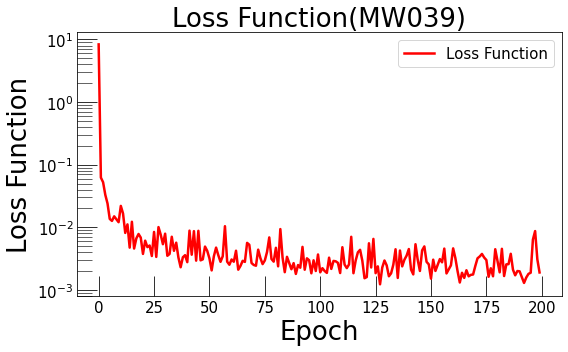

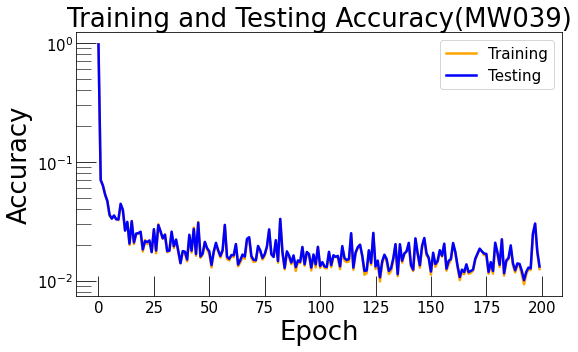

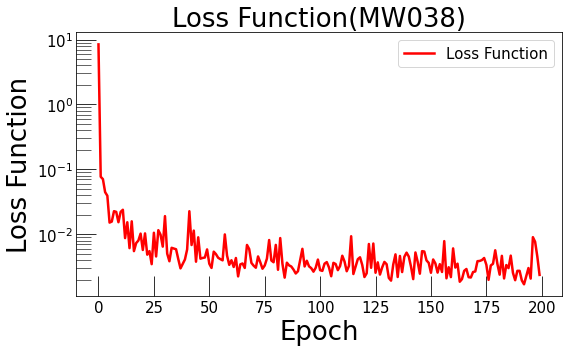

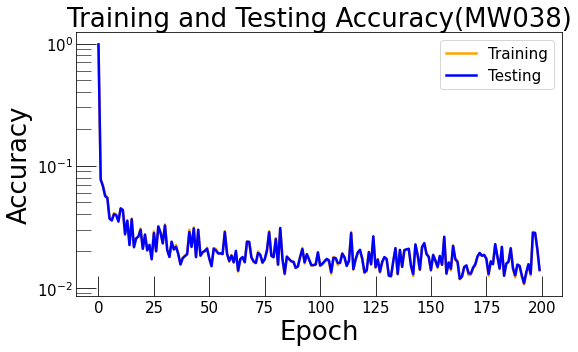

In [27]:
save_dir = get_save_dir(LP)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    print("Make a directory {}.".format(save_dir))
ANN.plot_figures(save_dir, LP.save_fig_type)